In [12]:
import os
import sys
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import matplotlib.image as mpimg
from matplotlib.image import imread
from PIL import Image
import torch
from torchvision import transforms

from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [2]:
current_working_directory = os.getcwd()
print(current_working_directory)

dataset_path = os.path.join(current_working_directory,"US_Dataset_BUSI")
print(dataset_path)

/Users/ashwin/Padhai/Projects/RKT_BC
/Users/ashwin/Padhai/Projects/RKT_BC/US_Dataset_BUSI


In [3]:
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Ensure that the image is loaded as grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Adjust for grayscale images
])

augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x) if isinstance(x, torch.Tensor) else x), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

def load_and_preprocess_image(image_path, apply_augmentation=False):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    transform = augmentation_transform if apply_augmentation else original_transform
    img_tensor = transform(img)
    return img_tensor

In [4]:
data = []
labels = []

for class_name in ['benign','malignant']:
    class_path = os.path.join(dataset_path, class_name)

    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        if "mask" in image_file:
            continue
        original_img_data = load_and_preprocess_image(image_path, apply_augmentation=False)
        augmented_img_data = load_and_preprocess_image(image_path, apply_augmentation=True)
        data.append(original_img_data)
        data.append(augmented_img_data)

        label = 0 if class_name == "benign" else 1
        labels.extend([label,label])

data = torch.stack(data)
labels = torch.tensor(labels)

df = pd.DataFrame({"ImageTensor": list(data), "Class": labels})

In [5]:
df

,ImageTensor,Class
0,"[[[tensor(-0.9534), tensor(0.0056), tensor(0.0...",0
1,"[[[tensor(-2.1179), tensor(-2.1179), tensor(-2...",0
2,"[[[tensor(-1.6042), tensor(-1.2959), tensor(0....",0
3,"[[[tensor(-2.0323), tensor(-2.0323), tensor(-2...",0
4,"[[[tensor(-1.5357), tensor(-0.1143), tensor(-0...",0
...,...,...
1289,"[[[tensor(-1.9809), tensor(-1.9809), tensor(-1...",1
1290,"[[[tensor(-1.6727), tensor(0.3309), tensor(-1....",1
1291,"[[[tensor(-2.1179), tensor(-2.1179), tensor(-2...",1
1292,"[[[tensor(-2.0494), tensor(-2.0323), tensor(-1...",1


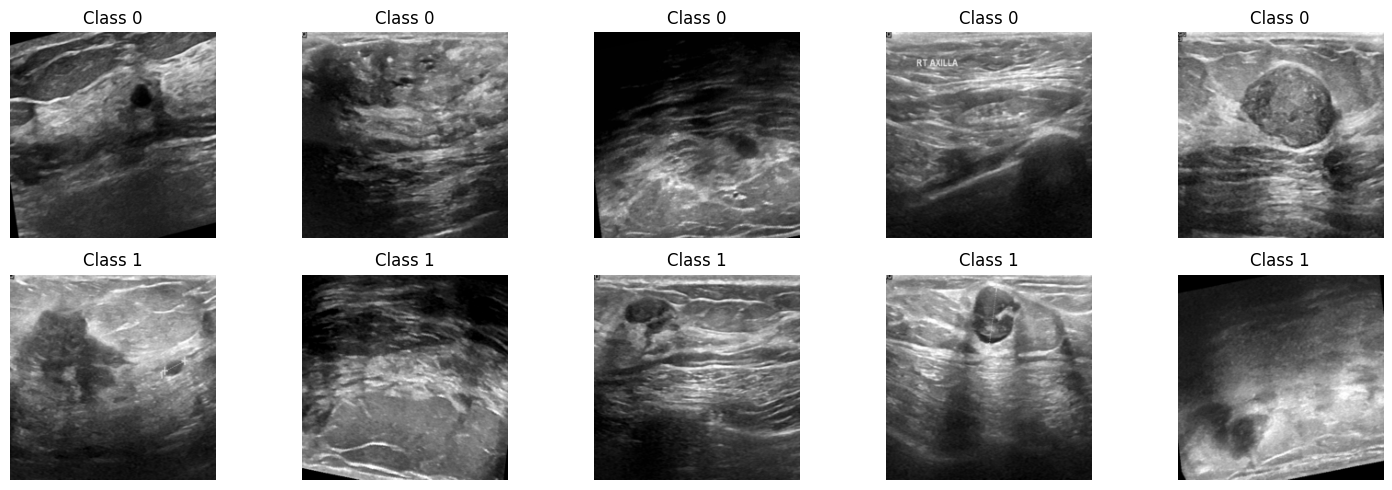

In [13]:
def tensor_to_np(tensor):
    img_np = tensor.numpy().transpose((1, 2, 0))
    return img_np

def plot_sample_images(df, num_samples=5):
    class_0_samples = df[df['Class'] == 0].sample(num_samples)
    class_1_samples = df[df['Class'] == 1].sample(num_samples)

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

    # Plot class 0 samples
    for i, (_, row) in enumerate(class_0_samples.iterrows()):
        img_tensor = row['ImageTensor']
        img_np = tensor_to_np(img_tensor)
        ax = axes[0, i]
        ax.imshow(img_np, cmap='gray')
        ax.set_title('Class 0')
        ax.axis('off')

    # Plot class 1 samples
    for i, (_, row) in enumerate(class_1_samples.iterrows()):
        img_tensor = row['ImageTensor']
        img_np = tensor_to_np(img_tensor)
        ax = axes[1, i]
        ax.imshow(img_np, cmap='gray')
        ax.set_title('Class 1')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(df)

In [14]:
df = df.sample(frac=1).reset_index(drop=True)

train_df, test_val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

print("Train set:", len(train_df))
print("Validation set:", len(val_df))
print("Test set:", len(test_df))

Train set: 1035
Validation set: 129
Test set: 130


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [8]:
model = SimpleCNN()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

12938433


In [9]:
from torchsummary import summary
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
          Flatten-10               [-1, 100352]               0
           Linear-11                  [-1, 128]      12,845,184
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'ImageTensor': self.data.iloc[idx]['ImageTensor'], 'Class': self.data.iloc[idx]['Class']}
        
        if self.transform:
            sample['ImageTensor'] = self.transform(sample['ImageTensor'])

        return sample

In [11]:
train_df

,ImageTensor,Class
1068,"[[[tensor(-1.4843), tensor(-0.8507), tensor(-0...",0
967,"[[[tensor(-0.7822), tensor(-0.0287), tensor(-0...",0
803,"[[[tensor(-2.1179), tensor(-1.7925), tensor(-1...",0
339,"[[[tensor(-2.1179), tensor(-2.1179), tensor(-2...",0
667,"[[[tensor(-1.9809), tensor(-1.9809), tensor(-1...",1
...,...,...
1044,"[[[tensor(-2.0837), tensor(-2.0494), tensor(-1...",1
1095,"[[[tensor(0.7591), tensor(0.7248), tensor(-0.6...",0
1130,"[[[tensor(-0.4568), tensor(0.6392), tensor(-1....",1
860,"[[[tensor(-2.1179), tensor(-2.1179), tensor(-2...",0


In [12]:
train_dataset = CustomDataset(train_df, transform=None)
val_dataset = CustomDataset(val_df, transform=None)
test_dataset = CustomDataset(test_df, transform=None)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    x = torch.ones(1, device=device)
    print(x)
else:
    print("MPS device not found")

tensor([1.], device='mps:0')


In [15]:
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
from tqdm import tqdm 

num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

    for batch in progress_bar:
        images, labels = batch['ImageTensor'].to(device), batch['Class'].float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        predictions = (outputs >= 0.5).float()
        correct_predictions += torch.sum(predictions == labels).item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Loss': loss.item()})

    training_accuracy = correct_predictions / total_samples
    progress_bar.close()
    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Training Accuracy:{training_accuracy}")

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    progress_bar = tqdm(val_loader, desc='Validation', leave=False)
    for batch in progress_bar:
        images, labels = batch['ImageTensor'].to(device), batch['Class'].float().unsqueeze(1).to(device)
        outputs = model(images)
        
        predictions = (outputs >= 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    progress_bar.close()

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Epoch 1/40:   0%|          | 0/33 [00:00<?, ?it/s]

/Users/ashwin/miniconda3/envs/torch/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 1/40, Loss: 0.801282165628491, Training Accuracy:0.6386473429951691


Epoch 2/40, Loss: 0.5507753437215631, Training Accuracy:0.7352657004830918


Epoch 3/40, Loss: 0.5287321923357068, Training Accuracy:0.7478260869565218


Epoch 4/40, Loss: 0.5009547300410994, Training Accuracy:0.7719806763285024


Epoch 5/40, Loss: 0.45228016105565155, Training Accuracy:0.808695652173913


Epoch 6/40, Loss: 0.4315922725381273, Training Accuracy:0.8009661835748793


Epoch 7/40, Loss: 0.4030494066801938, Training Accuracy:0.8222222222222222


Epoch 8/40, Loss: 0.3729216212576086, Training Accuracy:0.8357487922705314


Epoch 9/40, Loss: 0.3502497203422315, Training Accuracy:0.8521739130434782


Epoch 10/40, Loss: 0.2972586563590801, Training Accuracy:0.8792270531400966


Epoch 11/40, Loss: 0.2920347330245105, Training Accuracy:0.8782608695652174


Epoch 12/40, Loss: 0.2684421959248456, Training Accuracy:0.8927536231884058


Epoch 13/40, Loss: 0.23307504753271738, Training Accuracy:0.9033816425120773


Epoch 14/40, Loss: 0.2172105980641914, Training Accuracy:0.9169082125603865


Epoch 15/40, Loss: 0.1940987663287105, Training Accuracy:0.9314009661835749


Epoch 16/40, Loss: 0.20175104904355426, Training Accuracy:0.9198067632850242


Epoch 17/40, Loss: 0.1747549386187033, Training Accuracy:0.9371980676328503


Epoch 18/40, Loss: 0.1640185725056764, Training Accuracy:0.9371980676328503


Epoch 19/40, Loss: 0.16013442476590475, Training Accuracy:0.9371980676328503


Epoch 20/40, Loss: 0.1353162960572676, Training Accuracy:0.9545893719806763


Epoch 21/40, Loss: 0.13273874692844623, Training Accuracy:0.957487922705314


Epoch 22/40, Loss: 0.11863071584340298, Training Accuracy:0.957487922705314


Epoch 23/40, Loss: 0.09840559711058934, Training Accuracy:0.9710144927536232


Epoch 24/40, Loss: 0.10624502136400252, Training Accuracy:0.9555555555555556


Epoch 25/40, Loss: 0.09777636272889195, Training Accuracy:0.9671497584541063


Epoch 26/40, Loss: 0.08422581501530879, Training Accuracy:0.978743961352657


Epoch 27/40, Loss: 0.09628181819888679, Training Accuracy:0.9652173913043478


Epoch 28/40, Loss: 0.08215603559757724, Training Accuracy:0.9719806763285024


Epoch 29/40, Loss: 0.0731722405462554, Training Accuracy:0.9816425120772947


Epoch 30/40, Loss: 0.06145314731155381, Training Accuracy:0.9777777777777777


Epoch 31/40, Loss: 0.07875559117757913, Training Accuracy:0.970048309178744


Epoch 32/40, Loss: 0.06542524983259765, Training Accuracy:0.9768115942028985


Epoch 33/40, Loss: 0.058980065087477364, Training Accuracy:0.978743961352657


Epoch 34/40, Loss: 0.06927329623563723, Training Accuracy:0.9758454106280193


Epoch 35/40, Loss: 0.059589948392275605, Training Accuracy:0.9748792270531401


Epoch 36/40, Loss: 0.06343651997546355, Training Accuracy:0.9758454106280193


Epoch 37/40, Loss: 0.05580727984620766, Training Accuracy:0.9835748792270531


Epoch 38/40, Loss: 0.05757848300378431, Training Accuracy:0.9806763285024155


Epoch 39/40, Loss: 0.053498814051801506, Training Accuracy:0.9835748792270531


Epoch 40/40, Loss: 0.050857672044499355, Training Accuracy:0.9835748792270531


Validation Accuracy: 83.72%


In [17]:
model.eval()
all_predictions_test = []
all_labels_test = []

with torch.no_grad():
    for batch in test_loader:
        images_test, labels_test = batch['ImageTensor'].to(device), batch['Class'].float().unsqueeze(1).to(device)
        outputs_test = model(images_test)
        
        predictions_test = (outputs_test >= 0.5).float()
        all_predictions_test.extend(predictions_test.cpu().numpy())
        all_labels_test.extend(labels_test.cpu().numpy())

accuracy_test = accuracy_score(all_labels_test, all_predictions_test)
print(f"Testing Accuracy: {accuracy_test * 100:.2f}%")

Testing Accuracy: 78.46%
